In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [81]:
sns.set()
%matplotlib inline

In [82]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
%autoreload 2

In [84]:
from sir_models.seir import SEIR
from sir_models.seir import stepwise, get_quarantine_multiplier_value

# Load data

In [85]:
df = pd.read_csv('data/data.csv', sep=';')

In [86]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [87]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [88]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


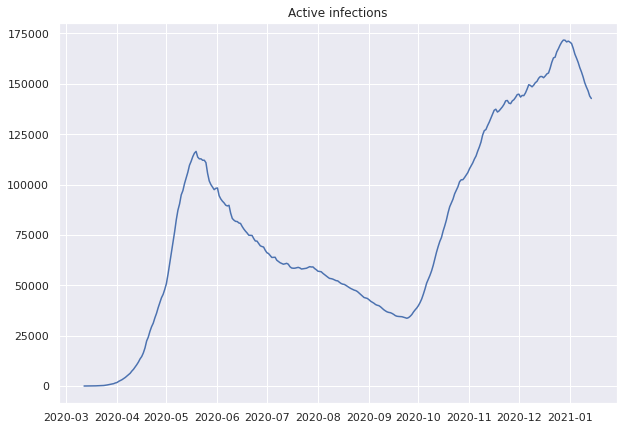

In [142]:
plt.figure(figsize=(10,7))
plt.plot(df.date, df.infected)
plt.title("Active infections")
plt.show()

# Model

In [238]:
train_subset = df[(df.date >= '2020-03-25') & (df.date <= '2020-11-30')]

In [239]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

264   2020-12-01
265   2020-12-02
266   2020-12-03
267   2020-12-04
268   2020-12-05
269   2020-12-06
270   2020-12-07
271   2020-12-08
272   2020-12-09
273   2020-12-10
274   2020-12-11
275   2020-12-12
276   2020-12-13
277   2020-12-14
278   2020-12-15
279   2020-12-16
280   2020-12-17
281   2020-12-18
282   2020-12-19
283   2020-12-20
284   2020-12-21
285   2020-12-22
286   2020-12-23
287   2020-12-24
288   2020-12-25
289   2020-12-26
290   2020-12-27
291   2020-12-28
292   2020-12-29
293   2020-12-30
294   2020-12-31
295   2021-01-01
296   2021-01-02
297   2021-01-03
298   2021-01-04
299   2021-01-05
300   2021-01-06
301   2021-01-07
302   2021-01-08
303   2021-01-09
304   2021-01-10
305   2021-01-11
306   2021-01-12
307   2021-01-13
308   2021-01-14
Name: date, dtype: datetime64[ns]

In [255]:
model = SEIR()
model.fit(train_subset)

S, E, I, R, D = model.predict_train()

result = model.fit_result_
result

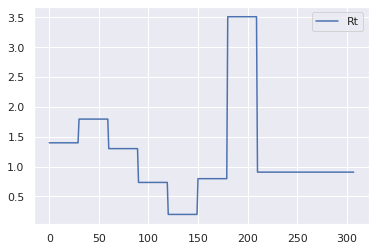

In [256]:
r0 = model.params['r0']
gamma = model.params['gamma']

rt_vals = []
for t in range(1, len(df)):
    rt_vals.append(r0 - get_quarantine_multiplier_value(t, model.params) * r0)
    
plt.figure()
plt.plot(rt_vals, label='Rt')
plt.legend()
plt.show()

In [257]:
np.mean(rt_vals)

1.2372525249085022

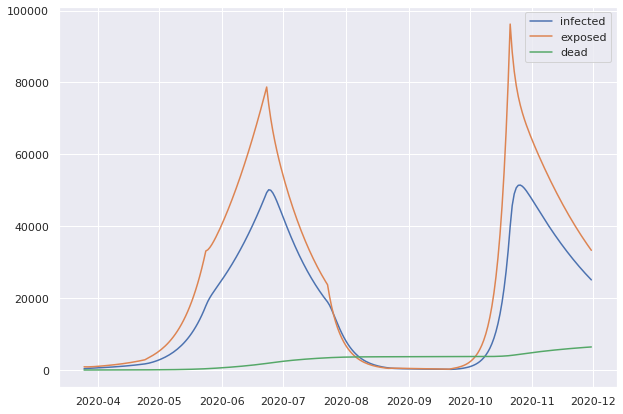

In [258]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, I, label='infected')
plt.plot(train_subset.date, E, label='exposed')
plt.plot(train_subset.date, D, label='dead')
plt.legend()
plt.show()

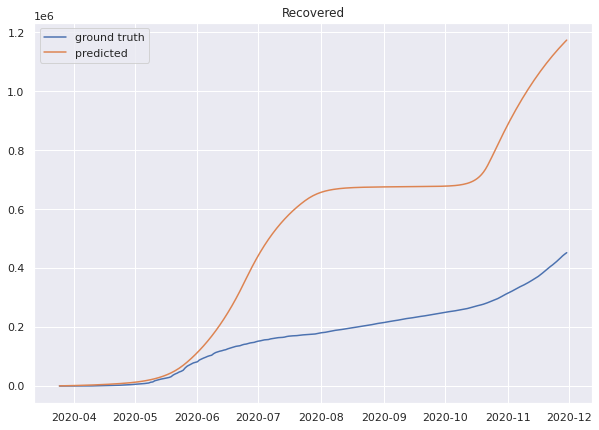

In [259]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

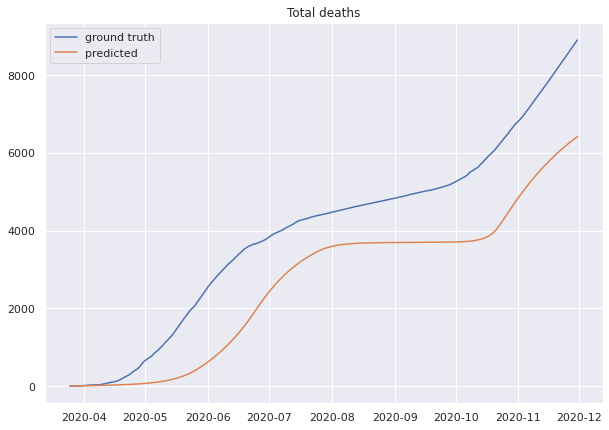

In [260]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

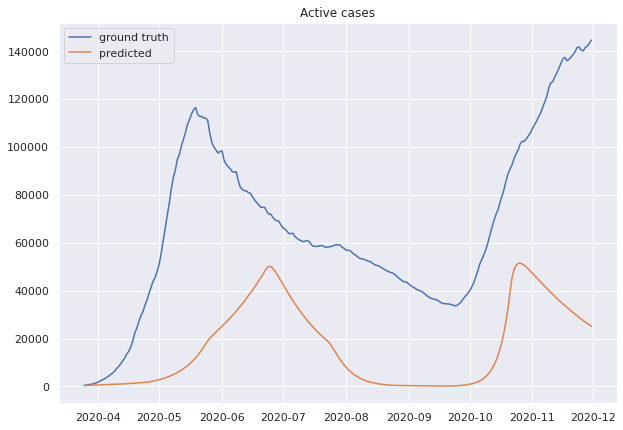

In [261]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='ground truth')
plt.plot(train_subset.date, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

# Obtain forecast

In [262]:
test_t = len(train_subset) + np.arange(len(test_subset))

test_S, test_E, test_I, test_R, test_D = model.predict_test(test_t)

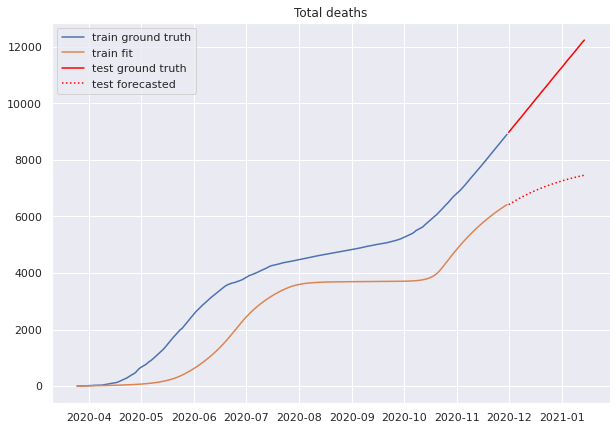

In [263]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

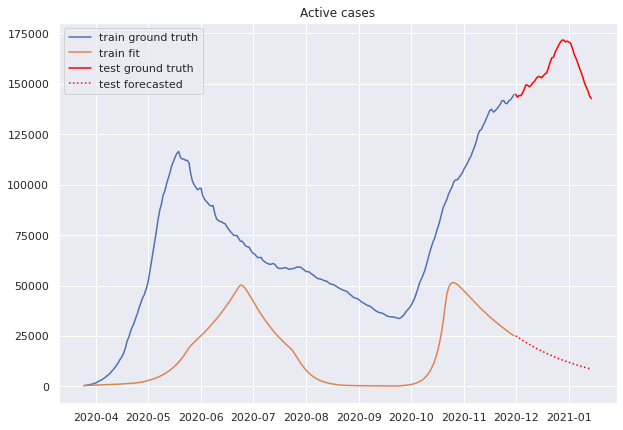

In [272]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_'], label='train ground truth')
plt.plot(train_subset.date, I, label='train fit')

plt.plot(test_subset.date, test_subset['infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_I, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Active cases')
plt.show()

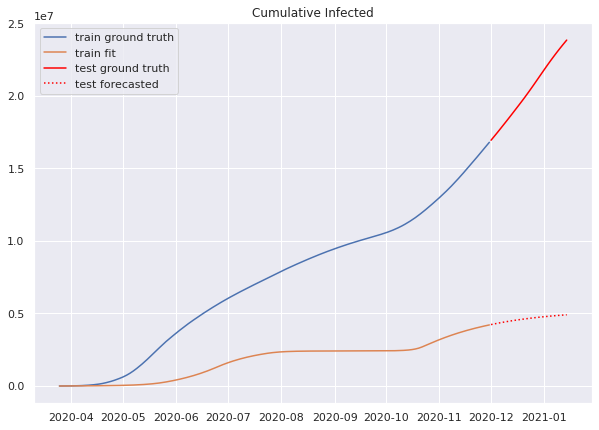

In [297]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected'].sum()+test_subset['infected'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative Infected')
plt.show()

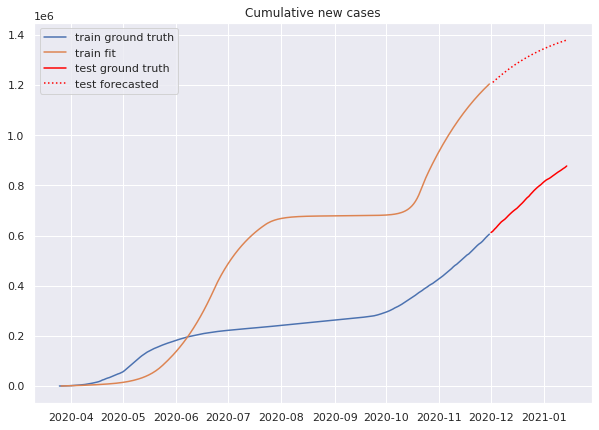

In [296]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected_per_day'].sum()+test_subset['infected_per_day'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date,  (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).sum()+(pd.Series(test_I).diff() + pd.Series(test_R).diff() + pd.Series(test_D).diff()).cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative new cases')
plt.show()

# Future forecast

In [265]:
future_dates = pd.date_range(start=df.iloc[-1].date, periods=365//2)

future_t = np.arange(test_t[-1], test_t[-1]+len(future_dates))

assert len(future_dates) == len(future_t)

In [266]:
test_future_t = np.concatenate([test_t, future_t])

In [267]:
future_S, future_E, future_I, future_R, future_D = model.predict_test(test_future_t)

future_S, future_E, future_I, future_R, future_D = future_S[len(test_t):], future_E[len(test_t):], future_I[len(test_t):], future_R[len(test_t):], future_D[len(test_t):]

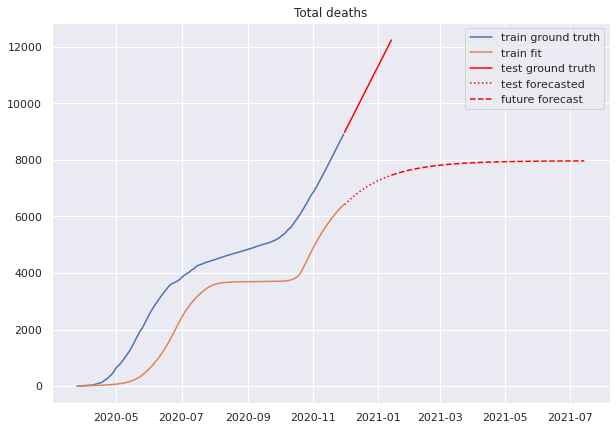

In [268]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted', color='red', linestyle=':')

plt.plot(future_dates, future_D, label='future forecast', color='red', linestyle='--')
plt.legend()
plt.title('Total deaths')
plt.show()

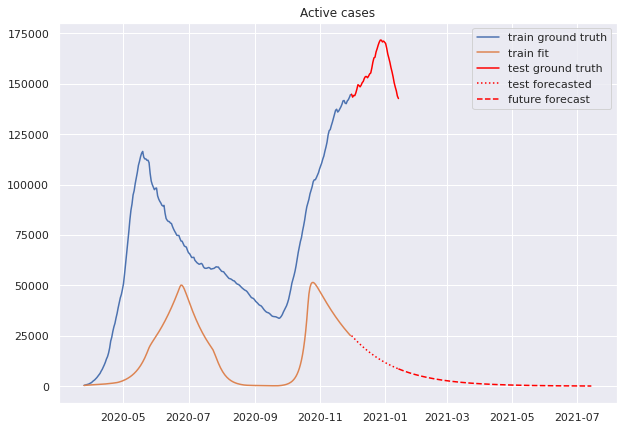

In [269]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='train ground truth')
plt.plot(train_subset.date, I, label='train fit')

plt.plot(test_subset.date, test_subset['infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_I, label='test forecasted', color='red', linestyle=':')

plt.plot(future_dates, future_I, label='future forecast', color='red', linestyle='--')
plt.legend()
plt.title('Active cases')
plt.show()